In [1]:
#basic analysis package
import numpy as np
import pandas as pd
from pathlib import Path
import tifffile as tf
from importlib import reload
#enable relative import
import sys 
sys.path.append("..")
from helpers.util import pil_imread
#cusom packages
import fiducial_alignment_affine as fa_affine

In [2]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

def plot_2d_image(img_2d, zmax=1000, animation = True):
    
    if animation == True:   
    #For Plotting 2d image
        #-------------------------------------------
        fig = px.imshow(
            img_2d,
            width=700,
            height=700,
            binary_string=True,
            binary_compression_level=4,
            binary_backend='pil',
            zmax = zmax,
            animation_frame=0
        )
        #-------------------------------------------

        fig.show()
    else:
        #For Plotting 2d image
        #-------------------------------------------
        fig = px.imshow(
            img_2d,
            width=700,
            height=700,
            binary_string=True,
            binary_compression_level=4,
            binary_backend='pil',
            zmax = zmax,
        )
        #-------------------------------------------

        fig.show()

In [3]:
def plot_2d_locs_on_2d_image(df_locs_2d_1, img_2d, zmax=1000):
    
    #For Plotting 2d image
    #-------------------------------------------
    fig = px.imshow(
        img_2d,
        width=700,
        height=700,
        binary_string=True,
        binary_compression_level=4,
        binary_backend='pil',
        zmax = zmax
    )
    #-------------------------------------------
    
    #For Plotting 2d dots
    #-------------------------------------------
    fig.add_trace(go.Scattergl(
        x=df_locs_2d_1.x,
        y=df_locs_2d_1.y,
        mode='markers',
        marker_symbol='cross',
        marker=dict(
            #maxdisplayed=1000,
            size=4
            ),
        name = "Gaussian"
        )
    )
    #-------------------------------------------
    
    fig.show()

In [4]:
#get image paths
Pos = 0
bead_src = Path("/groups/CaiLab/personal/Lex/raw/230708_3k_1nM_split_IP_tmg/chromatic_aberration")
bead_src = bead_src / f"MMStack_Pos{Pos}.ome.tif"

tiff_src = Path("/groups/CaiLab/personal/Lex/raw/230708_3k_1nM_split_IP_tmg/pyfish_tools/output/dapi_aligned/HybCycle_0")
tiff_src = tiff_src / f"MMStack_Pos{Pos}.ome.tif"

# tiff_src_noalign = Path("")
# tiff_src_noalign = tiff_src_noalign / f"MMStack_Pos{Pos}.ome.tif"

In [ ]:
beads = pil_imread(str(bead_src),num_channels=4, swapaxes=True)

In [ ]:
beads.shape

In [ ]:
#read in image
raw = pil_imread((str(tiff_src)), num_channels=4, swapaxes=True)

In [ ]:
raw

In [ ]:
raw.shape

In [ ]:
beads.shape

In [ ]:
#look at beads
plot_2d_image(beads[0], zmax=2000)

In [ ]:
#look at raw
plot_2d_image(raw[0], zmax=2000)

In [ ]:
#check how off
plot_2d_image(np.array([raw[0][0],beads[0][0]]), zmax=1000)

# Test fiducial alignment on one position

TiffPage 0: TiffFileError: invalid tag value offset
TiffPages: invalid page offset 167795808


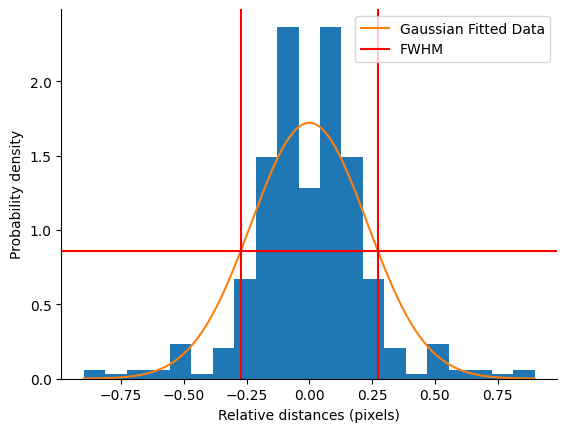

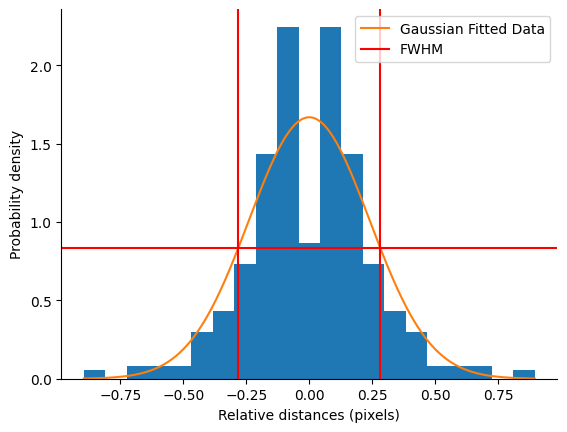

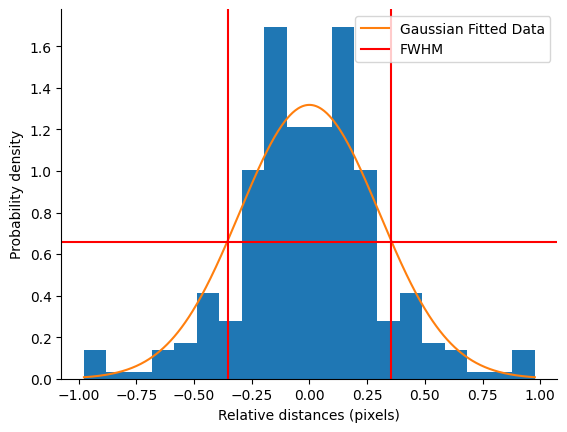

This task took 1.1244181076685587 min


In [5]:
import time
start = time.time()

#set bead channel to None if there are beads in all channels

image,error = fa_affine.fiducial_alignment_single(tiff_src, bead_src, threshold_abs=500, 
                                                  max_dist=1,ransac_threshold=0.5, bead_channel_single=None,
                                                  include_dapi=False,use_ref_coord=True, 
                                                  num_channels=4, write=False)
print(f"This task took {(time.time()-start)/60} min")

In [6]:
#look at displacement ([channel, percent change, displacement])
error

,Channels,Percent Improvement,FWHM
0,0,0.249900,0.543690
1,1,0.050594,0.562786
2,2,0.012962,0.708587


In [ ]:
#look at image to make sure transform looks normal
plot_2d_image(image[0], zmax=3000)

In [ ]:
#check how off
plot_2d_image(np.array([beads[0][0],image[0][0]]), zmax=5000)

# Check average fwhm per field of view

In [ ]:
hybs = np.arange(0,7,1)
poss = np.arange(0,97,1)
bad_pos = []
bad_pos_and_hyb = []
for hyb in hybs:
    for pos in poss:
        #check if file exists
        try:
            src = f""
            error = pd.read_csv(src, sep = " ", header=None)
        except:
            bad_pos.append(pos)
            bad_pos_and_hyb.append([hyb,pos])

error_list = []
filt_pos = set(poss) - set(bad_pos) 
for hyb in hybs:
    for pos in filt_pos:
        src = f""
        error = pd.read_csv(src, sep = " ", header=None)
        error_list.append(error)

In [ ]:
comb_error = pd.concat(error_list)
comb_error.columns = ["channel", "percent improvement", "fwhm"]

In [ ]:
comb_error.groupby("channel").sem()["fwhm"]

In [ ]:
comb_error.groupby("channel").mean()["fwhm"]

In [ ]:
#positions that didn't fiducial align
np.unique(bad_pos)

In [ ]:
#position and hyb
bad_pos_and_hyb